In [1]:
import torch
import requests
import numpy as np
import pandas as pd 
import torch.nn as nn 
import torch.optim as optim

# Generative Adversarial Neural Network (GAN)

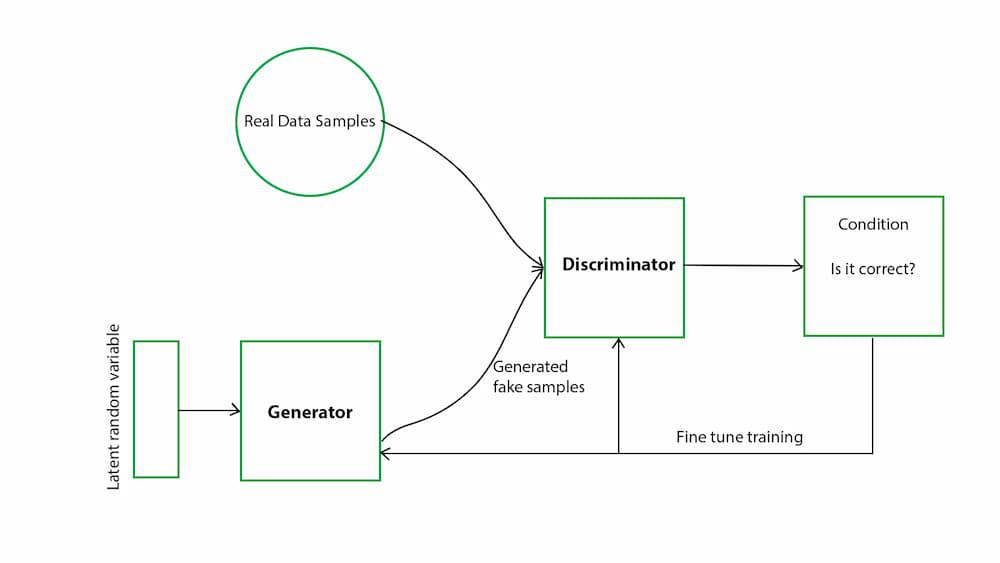

# Data Retrival

In [2]:
url = "https://raw.githubusercontent.com/rashida048/Datasets/master/home_data.csv"
data = pd.read_csv(url)

In [3]:
import requests
import pandas as pd


url = "https://lib.stat.cmu.edu/datasets/boston"
response = requests.get(url)
data_str = response.text

lines = data_str.splitlines()


data_lines = lines[22:]  

parsed_rows = []
for i in range(0, len(data_lines), 2):
    # Each row in the dataset is split across 2 lines
    row1 = data_lines[i].split()
    row2 = data_lines[i+1].split()
    row = row1 + row2  # combine them
    parsed_rows.append(row)



column_names = [
    "CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS",
    "RAD","TAX","PTRATIO","B","LSTAT","MEDV"
]

df = pd.DataFrame(parsed_rows, columns=column_names).astype(float)

In [4]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


1) CRIM:     per capita crime rate by town
2) ZN:       proportion of residential land zoned for lots over 25,000 sq.ft.
3) INDUS:    proportion of non-retail business acres per town
4) CHAS:     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5) NOX:      nitric oxides concentration (parts per 10 million)
6) RM:       average number of rooms per dwelling
7) AGE:      proportion of owner-occupied units built prior to 1940
8) DIS:      weighted distances to five Boston employment centers
9) RAD:      index of accessibility to radial highways
10) TAX:      full-value property-tax rate per \$10,000
11) PTRATIO:  pupil-teacher ratio by town
12) B:        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13) LSTAT:    \% lower status of the population
14) MEDV:     Median value of owner-occupied homes in \$1000's

In [6]:
df.CHAS.value_counts()

CHAS
0.0    471
1.0     35
Name: count, dtype: int64

# Preprocessing

In [7]:
from sklearn.ensemble import IsolationForest

## Remove Outliers: IQR Method

In [9]:
Q1 = df['MEDV'].quantile(0.25)
Q3 = df['MEDV'].quantile(0.75)

# Compute the IQR
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [10]:
filtered_df = df[(df['MEDV'] >= lower_bound) & (df['MEDV'] <= upper_bound)]

In [11]:
len(df[df.MEDV <= lower_bound])

2

In [12]:
len(df[df.MEDV >= upper_bound])

38

In [13]:
len(df) - len(filtered_df)

40

### Train-Test Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X, y = filtered_df.iloc[:,:-1], filtered_df.iloc[:, -1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize

In [18]:
from sklearn.preprocessing import StandardScaler

In [259]:
exclude_indices = ["CRIM", "CHAS", "RAD"]
rad = X_train["RAD"]/max(X_train.RAD)
crim = np.log(X_train.CRIM)

x1 = pd.concat([crim, X_train.CHAS, rad,],axis=1)
scale_indices = [i for i in df.columns if i not in exclude_indices]

exclude_idx = [ i for i,j in enumerate(df.columns) if j  in exclude_indices]
scale_idx = [i for i,j in enumerate(df.columns) if j not in exclude_indices]

In [260]:
X_train_ = pd.concat([X_train, y_train],axis=1)
X_test_ = pd.concat([X_test, y_test],axis=1)

In [261]:
scaler = StandardScaler().fit(X_train_[scale_indices])
X_train_scaled = scaler.transform(X_train_[scale_indices])
X_test_scaled = scaler.transform(X_test_[scale_indices])

X_train_final = np.zeros_like(X_train_)
X_train_final[:, scale_idx] = X_train_scaled
X_train_final[:, exclude_idx] = x1.values

### Dataloader

In [262]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(X_train_final.astype(np.float32), batch_size=64, shuffle=True)
#test_dataloader = DataLoader(X_test_scaled.astype(np.float32), batch_size=64, shuffle=True)

# WGAN

In [263]:
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                nn.PReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.PReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.PReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.PReLU(),
                                nn.Linear(hidden_dim,output_dim)
                                 
        )

    def forward(self, x):
        x = self.net(x)
        x[:, 3] = torch.sigmoid(x[:,3])
        x[:, 8] = torch.sigmoid(x[:,8]) 
        
        return x
    
class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
                                nn.Linear(input_dim, hidden_dim),
                                nn.PReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.PReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.PReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.PReLU(),
                                nn.Linear(hidden_dim,output_dim)
                                 
        )

    def forward(self, x):
        x = self.net(x)
        return x
    

    

## Gadient Penalty

In [264]:
def gradient_penalty(critic, real_data, fake_data, device, lambda_gp=10):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, device=device)
    epsilon = epsilon.expand_as(real_data)

    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    interpolated_scores = critic(interpolated)

    grad_outputs = torch.ones_like(interpolated_scores)
    gradients = torch.autograd.grad(
        outputs=interpolated_scores,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, dim=1)
    gp = ((grad_norm - 1) ** 2).mean() * lambda_gp
    return gp

## Hyperparameters

In [265]:
device = "cpu"

z_dim = 32 # dimension of latent space 
input_dim = output_dim = 14 #number of features 
hidden_dim = 64 #number of neuorons per layer


generator = Generator(z_dim, hidden_dim, output_dim).to(device)
critic = Critic(input_dim, hidden_dim).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=3e-4)
optimizer_C = optim.Adam(critic.parameters(), lr=5e-5)

# Loss Functions

### Wasserstein-1 Distance (Earth Movers Distance)

$$ W(P,Q) = \inf_{\gamma \in \Gamma(P,Q) } \mathbb{E}_{(x,y) \sim \gamma} || x - y|| $$
where $P$ and $Q$ are probability distributions and $\Gamma(P,Q)$ represents the set of all possible joint distributions with marginals $P$, $Q$. 

### Kantorovich-Rubinstein Dulaity

$$ W(P, Q) = \sup_{||f|| L \leq 1} \mathbb{E}_{x \sim P}[f(x)] - \mathbb{E}_{x \sim Q}[f(x)]$$
where $f$ is a 1-Lipschitz function (ie neural network)

## Training

In [266]:
#clip_value = 0.01 #clip gradient 
n_critic = 5 # number of times to train critic
lambda_gp = 5 #gradient penalty
epochs = 5000


for epoch in range(epochs):
    for i, real_data in enumerate(train_dataloader):
        real_data = real_data.to(device)
        batch_size = real_data.size(0)

        # =======================
        # Train Critic 
        # =======================
        for _ in range(n_critic):
            optimizer_C.zero_grad()

            # Sample random noise N(0, 1)
            noise = torch.randn(batch_size, z_dim, device=device)
            fake_data = generator(noise).detach()

            # Wasserstein loss for critic
            real_score = critic(real_data).mean()
            fake_score = critic(fake_data).mean()
            wasserstein_loss = fake_score - real_score
            
            #gradient penalty
            gp = gradient_penalty(critic, real_data, fake_data, device, lambda_gp)

            loss_C = wasserstein_loss + gp

            loss_C.backward()
            
            #torch.nn.utils.clip_grad_value_(critic.parameters(), clip_value)
            
            optimizer_C.step()

        # =======================
        # Train Generator 
        # =======================
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, z_dim, device=device)
        fake_data = generator(noise)
        gen_loss = -critic(fake_data).mean() # Generator loss: Minimize the negative mean critic score, pushing fake data towards real.

        gen_loss.backward()
        optimizer_G.step()

    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}]  Critic Loss: {loss_C.item():.4f}  Generator Loss: {gen_loss.item():.4f}")
print("Finished!")

Epoch [500/5000]  Critic Loss: -0.2161  Generator Loss: 0.7435
Epoch [1000/5000]  Critic Loss: -0.7382  Generator Loss: 5.7304
Epoch [1500/5000]  Critic Loss: 0.5848  Generator Loss: 6.9219
Epoch [2000/5000]  Critic Loss: -0.2789  Generator Loss: 8.5831
Epoch [2500/5000]  Critic Loss: -0.4454  Generator Loss: 7.7641
Epoch [3000/5000]  Critic Loss: -0.1302  Generator Loss: 7.6657
Epoch [3500/5000]  Critic Loss: -0.3145  Generator Loss: 9.6939
Epoch [4000/5000]  Critic Loss: -0.1267  Generator Loss: 9.6176
Epoch [4500/5000]  Critic Loss: -0.2718  Generator Loss: 8.1030
Epoch [5000/5000]  Critic Loss: -0.3960  Generator Loss: 7.6093
Finished!


# Evaluation

In [267]:
generator.eval()
with torch.no_grad():
    num_synthetic = len(X_train) 
    z = torch.randn(num_synthetic, z_dim, device=device)
    synthetic_data = generator(z).cpu().numpy()

fake_data = np.zeros_like(synthetic_data)
fake_data[:, scale_idx] = scaler.inverse_transform(synthetic_data[:,scale_idx])
fake_data[:, exclude_idx] = synthetic_data[:, exclude_idx]

fake_data[:,0] = np.exp(fake_data[:,0])
fake_data[:, 8] = fake_data[:,8]*max(X_train.RAD)
#fake_data[:,9] = fake_data[:,9]*max(X_train.TAX)


In [268]:
df_synthetic = pd.DataFrame(fake_data, columns=df.columns)

df_synthetic[df_synthetic < 0 ] = 0 
df_synthetic['CHAS'] = df_synthetic['CHAS'].apply(lambda x: 0 if x < 0.5 else 1)
df_synthetic.RAD = np.round(df_synthetic.RAD)
df_synthetic.TAX = np.round(df_synthetic.TAX)

In [269]:
df_synthetic.CHAS.value_counts()

CHAS
0    350
1     22
Name: count, dtype: int64

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [293]:
DF = pd.concat([X_train, y_train],axis=1)
DF2 = pd.concat([X_test, y_test], axis=1)
Y = df_synthetic.sample(len(DF2))

In [ ]:
import scienceplots
plt.style.use(['science'])
import latex

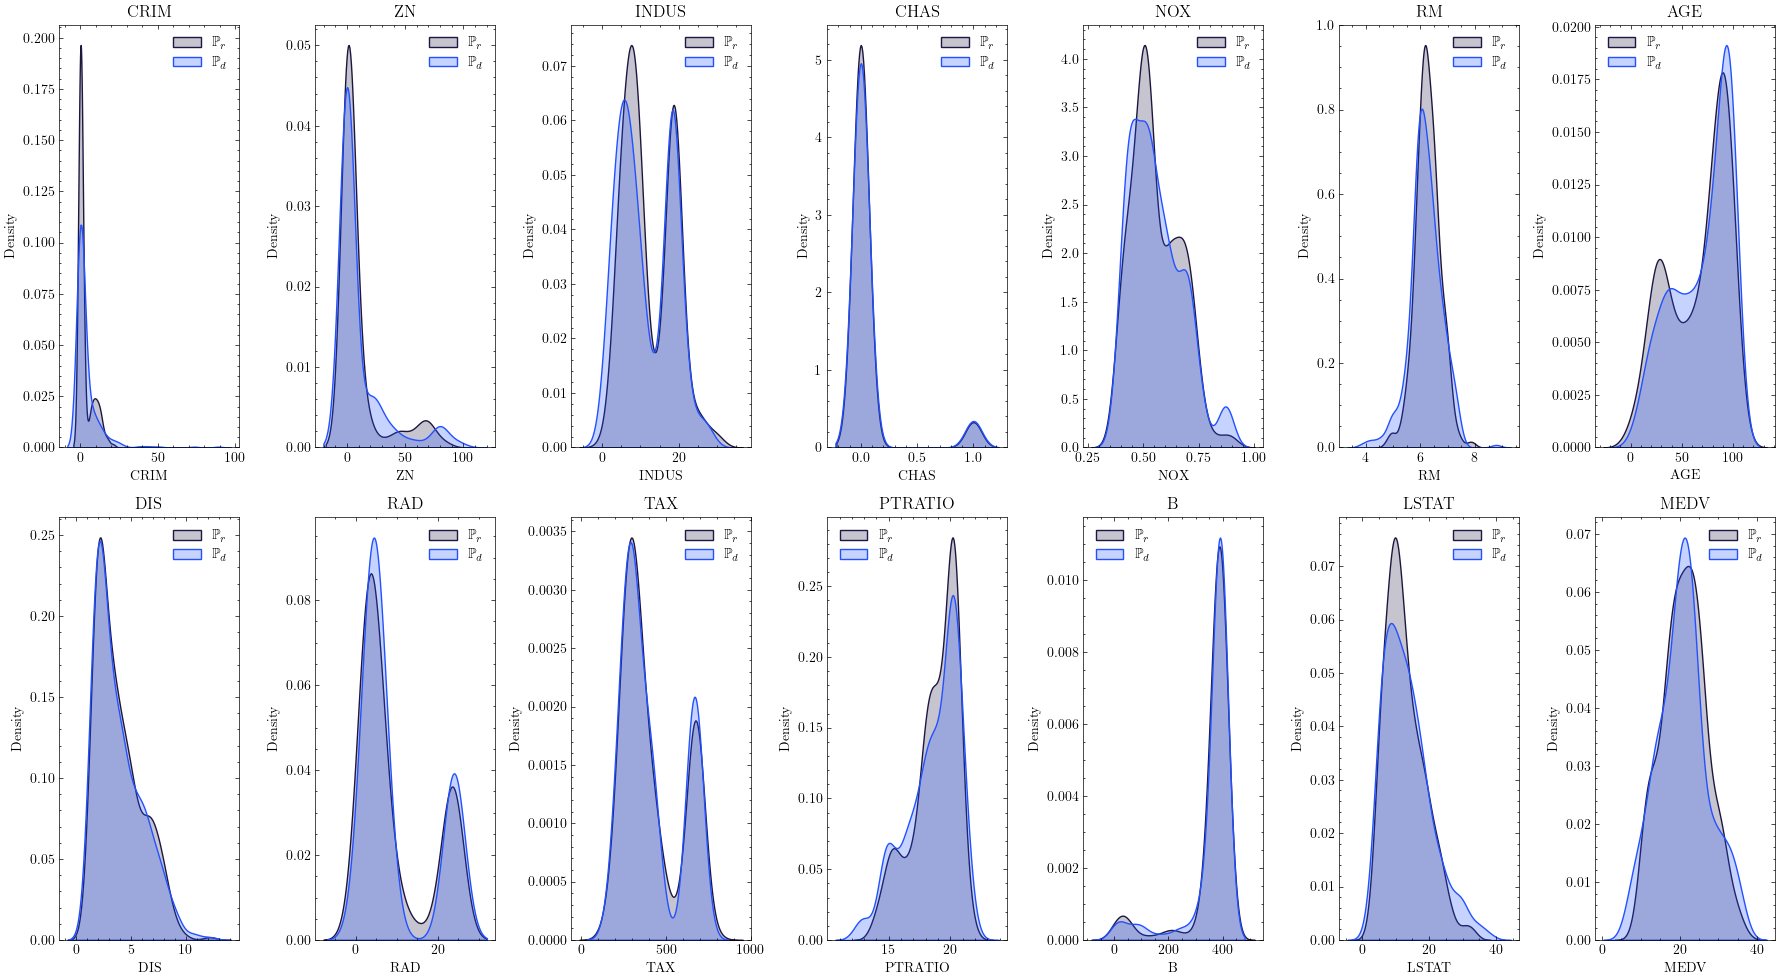

In [273]:
fig, axes = plt.subplots(2, 7, figsize=(18,10))
axes = axes.flatten() 

for i, col in enumerate(df.columns):
    sns.kdeplot(data=df_synthetic[col], ax=axes[i], label=r"$\mathbb{P}_r$", color="#1d1740", fill=True)
    sns.kdeplot(data=DF[col], ax=axes[i], label=r"$\mathbb{P}_d$", color="#2251ff", fill=True)
    axes[i].set_title(col)
    axes[i].legend() 

plt.tight_layout()  
plt.show()

fig.savefig('distributions.png', dpi=300)

1) CRIM:     per capita crime rate by town
2) ZN:       proportion of residential land zoned for lots over 25,000 sq.ft.
3) INDUS:    proportion of non-retail business acres per town
4) CHAS:     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5) NOX:      nitric oxides concentration (parts per 10 million)
6) RM:       average number of rooms per dwelling
7) AGE:      proportion of owner-occupied units built prior to 1940
8) DIS:      weighted distances to five Boston employment centers
9) RAD:      index of accessibility to radial highways
10) TAX:      full-value property-tax rate per \$10,000
11) PTRATIO:  pupil-teacher ratio by town
12) B:        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13) LSTAT:    \% lower status of the population
14) MEDV:     Median value of owner-occupied homes in \$1000's

# Wilcoxon Test

In [274]:
from scipy.stats import wilcoxon, wasserstein_distance

In [282]:
for feature in DF.columns:
    pval = wilcoxon(DF[feature], df_synthetic[feature]).pvalue
    if pval <= 0.05:
        print(f"Reject the null-hypothesis for feature: {feature}, there is a difference")
    else:
        print(f"Fail to reject null-hypothesis for feature: {feature}, there is no difference")
        
    
        

Fail to reject null-hypothesis for feature: CRIM, there is no difference
Fail to reject null-hypothesis for feature: ZN, there is no difference
Fail to reject null-hypothesis for feature: INDUS, there is no difference
Fail to reject null-hypothesis for feature: CHAS, there is no difference
Fail to reject null-hypothesis for feature: NOX, there is no difference
Fail to reject null-hypothesis for feature: RM, there is no difference
Fail to reject null-hypothesis for feature: AGE, there is no difference
Fail to reject null-hypothesis for feature: DIS, there is no difference
Fail to reject null-hypothesis for feature: RAD, there is no difference
Fail to reject null-hypothesis for feature: TAX, there is no difference
Fail to reject null-hypothesis for feature: PTRATIO, there is no difference
Fail to reject null-hypothesis for feature: B, there is no difference
Fail to reject null-hypothesis for feature: LSTAT, there is no difference
Fail to reject null-hypothesis for feature: MEDV, there is

In [295]:
for feature in DF2.columns:
    W = wasserstein_distance(DF2[feature], Y[feature])
    pval = wilcoxon(DF2[feature], Y[feature]).pvalue
    print(f"{feature} | Real Median {np.round(np.median(DF2[feature]),3)} | Fake Median {np.median(Y[feature]):.3f} | p-value = {pval:.3f} | W(P,Q): {W:.3f}")
        

CRIM | Real Median 0.218 | Fake Median 0.310 | p-value = 0.319 | W(P,Q): 0.834
ZN | Real Median 0.0 | Fake Median 0.519 | p-value = 0.985 | W(P,Q): 3.295
INDUS | Real Median 9.955 | Fake Median 10.561 | p-value = 0.240 | W(P,Q): 1.297
CHAS | Real Median 0.0 | Fake Median 0.000 | p-value = 0.739 | W(P,Q): 0.011
NOX | Real Median 0.538 | Fake Median 0.536 | p-value = 0.733 | W(P,Q): 0.019
RM | Real Median 6.212 | Fake Median 6.185 | p-value = 0.347 | W(P,Q): 0.100
AGE | Real Median 70.45 | Fake Median 77.316 | p-value = 0.917 | W(P,Q): 3.323
DIS | Real Median 3.574 | Fake Median 2.997 | p-value = 0.343 | W(P,Q): 0.281
RAD | Real Median 5.0 | Fake Median 5.000 | p-value = 0.418 | W(P,Q): 0.638
TAX | Real Median 387.5 | Fake Median 351.000 | p-value = 0.798 | W(P,Q): 15.500
PTRATIO | Real Median 19.2 | Fake Median 19.342 | p-value = 0.669 | W(P,Q): 0.164
B | Real Median 390.84 | Fake Median 388.213 | p-value = 0.782 | W(P,Q): 7.350
LSTAT | Real Median 11.83 | Fake Median 12.020 | p-value =

In [139]:
wilcoxon(y_train, df_synthetic.iloc[:, -1]).pvalue

0.7607302326840917

In [297]:
for feature in X_train.columns:
    W = wasserstein_distance(X_train[feature], np.random.choice(df_synthetic[feature], len(X_train)))
    print(f"Feature: {feature} | W(P,Q): {np.round(W, 3)} ")

Feature: CRIM | W(P,Q): 1.202 
Feature: ZN | W(P,Q): 2.982 
Feature: INDUS | W(P,Q): 1.231 
Feature: CHAS | W(P,Q): 0.011 
Feature: NOX | W(P,Q): 0.015 
Feature: RM | W(P,Q): 0.128 
Feature: AGE | W(P,Q): 3.109 
Feature: DIS | W(P,Q): 0.231 
Feature: RAD | W(P,Q): 0.806 
Feature: TAX | W(P,Q): 18.161 
Feature: PTRATIO | W(P,Q): 0.315 
Feature: B | W(P,Q): 9.204 
Feature: LSTAT | W(P,Q): 0.862 


# Fitting Models

## OLS

In [1866]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

In [1874]:
X_real = sm.add_constant(X_train)
y_real = y_train

X_synth = sm.add_constant(df_synthetic.drop("MEDV", axis=1))
y_synth = df_synthetic["MEDV"]

In [1875]:
ols_real = sm.OLS(y_real, X_real).fit()
ols_synth = sm.OLS(y_synth, X_synth).fit()

In [1876]:
print(f"Real R2: {ols_real.rsquared} \n")
print(f"Fake R2: {ols_synth.rsquared} \n")

Real R2: 0.7606706479591777 

Fake R2: 0.761788622520175 



In [1881]:
pred_real = ols_real.predict(sm.add_constant(X_test))
pred_synth = ols_synth.predict(sm.add_constant(X_test))

In [1882]:
mse_ols_real = mean_squared_error(y_test , pred_real)
mse_ols_synth = mean_squared_error(y_test, pred_synth)

r2_real = r2_score(y_test, pred_real)
r2_synth = r2_score(y_test, pred_synth)

In [1883]:
print(f"Real RMSE: {np.sqrt(mse_ols_real)}\n")
print(f"Fake RMSE: {np.sqrt(mse_ols_synth)}\n")

print(f"Real RMSE: {np.sqrt(r2_real)}\n")
print(f"Fake RMSE: {np.sqrt(r2_synth)}")

Real RMSE: 3.151077111463905

Fake RMSE: 3.243568608721

Real RMSE: 0.8674573664670543

Fake RMSE: 0.8589170979871582


In [1630]:
pvals_real = ols_real.pvalues
pvals_fake = ols_synth.pvalues

In [1631]:
print("Real vs. Fake p-values \n")
for i,j in enumerate(pvals_real):
    var = pvals_real.index[i]
    print(f"Variable: {var} | real p-value: {np.round(pvals_real[var],3)} | fake p-value: {np.round(pvals_fake[var],3)}")

Real vs. Fake p-values 

Variable: const | real p-value: 0.0 | fake p-value: 0.0
Variable: CRIM | real p-value: 0.001 | fake p-value: 0.066
Variable: ZN | real p-value: 0.009 | fake p-value: 0.722
Variable: INDUS | real p-value: 0.361 | fake p-value: 0.012
Variable: CHAS | real p-value: 0.325 | fake p-value: 0.432
Variable: NOX | real p-value: 0.0 | fake p-value: 0.0
Variable: RM | real p-value: 0.0 | fake p-value: 0.004
Variable: AGE | real p-value: 0.021 | fake p-value: 0.24
Variable: DIS | real p-value: 0.0 | fake p-value: 0.0
Variable: RAD | real p-value: 0.0 | fake p-value: 0.429
Variable: TAX | real p-value: 0.0 | fake p-value: 0.609
Variable: PTRATIO | real p-value: 0.0 | fake p-value: 0.0
Variable: B | real p-value: 0.0 | fake p-value: 0.392
Variable: LSTAT | real p-value: 0.0 | fake p-value: 0.0


## Random Forest

In [1884]:
from sklearn.ensemble import RandomForestRegressor

In [1889]:
rf_real = RandomForestRegressor(random_state=0).fit(X_train, y_train)
rf_synth = RandomForestRegressor(random_state=0).fit(X_synth.iloc[:,1:], y_synth)

In [1890]:
pred_real = rf_real.predict(X_test)
pred_synth = rf_synth.predict(X_test)

mse_real = mean_squared_error(y_test, pred_real)
mse_synth = mean_squared_error(y_test, pred_synth)

r2_real = r2_score(y_test, pred_real)
r2_synth = r2_score(y_test, pred_synth)

In [1891]:
print("Test Dataset \n")
print(f"RMSE Real: {np.sqrt(mse_real)} \n")
print(f"RMSE Fake: {np.sqrt(mse_synth)} \n")
print(f"R2 Real: {r2_real} \n")
print(f"R2 Fake: {r2_synth}")

Test Dataset 

RMSE Real: 2.4745770173695596 

RMSE Fake: 3.0939434706150024 

R2 Real: 0.847352330157236 

R2 Fake: 0.7613766282997199


## Neural Network

In [1892]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim,output_dim)
                                 
        )

    def forward(self, x):
        x = self.net(x)     
        return x

## Real

In [1905]:
neural_net_real = NeuralNet(13,64,1)
optimizer_real = optim.Adam(neural_net_real.parameters(), lr=3e-4)
mse = nn.MSELoss() 

In [1906]:
scaler_X = StandardScaler().fit(X_train.values)
scaler_y = StandardScaler().fit(y_train.values.reshape(-1,1))

X_norm = torch.tensor(scaler_X.transform(X_train.values), dtype=torch.float32)
y_norm = torch.tensor(scaler_y.transform(y_train.values.reshape(-1,1)), dtype=torch.float32)

In [1907]:
neural_net_real.train() 

for epoch in range(5000):

    optimizer_real.zero_grad()
    yhat = neural_net_real(X_norm)
    loss = mse(y_norm, yhat)
    loss.backward()
    optimizer_real.step()

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch + 1}/5000] | Loss: {loss.item():.4f}")

Epoch [500/5000] | Loss: 0.0250
Epoch [1000/5000] | Loss: 0.0047
Epoch [1500/5000] | Loss: 0.0013
Epoch [2000/5000] | Loss: 0.0008
Epoch [2500/5000] | Loss: 0.0003
Epoch [3000/5000] | Loss: 0.0008
Epoch [3500/5000] | Loss: 0.0002
Epoch [4000/5000] | Loss: 0.0000
Epoch [4500/5000] | Loss: 0.0000
Epoch [5000/5000] | Loss: 0.0000


In [1908]:
y_pred_real = neural_net_real(torch.tensor(scaler_X.transform(X_test.values), dtype=torch.float32))

In [1909]:
yhat_real = scaler_y.inverse_transform(y_pred_real.detach().numpy())

In [1910]:
mse_nn_real = mean_squared_error(y_test, yhat_real)
r2_nn_real = r2_score(y_test, yhat_real)

In [1932]:
print(f"Real RMSE: {np.sqrt(mse_nn_real)} \n")
print(f"Real R2: {r2_nn_real}")

Real RMSE: 2.8853869967578634 

Real R2: 0.7924626009981359


## Fake

In [1912]:
scaler_X_synth = StandardScaler().fit(X_synth.iloc[:, 1:].values)
scaler_y_synth = StandardScaler().fit(y_synth.values.reshape(-1,1))

X_norm_synth = torch.tensor(scaler_X_synth.transform(X_synth.iloc[:,1:].values), dtype=torch.float32)
y_norm_synth = torch.tensor(scaler_y_synth.transform(y_synth.values.reshape(-1,1)), dtype=torch.float32)

In [1913]:
neural_net_fake = NeuralNet(13,64,1)
optimizer_fake = optim.Adam(neural_net_fake.parameters(), lr=3e-4)
mse = nn.MSELoss() 

In [1914]:
neural_net_fake.train() 

for epoch in range(5000):

    optimizer_fake.zero_grad()
    yhat = neural_net_fake(X_norm_synth)
    loss = mse(y_norm_synth, yhat)
    loss.backward()
    optimizer_fake.step()

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch + 1}/5000] | Loss: {loss.item():.4f}")

Epoch [500/5000] | Loss: 0.0084
Epoch [1000/5000] | Loss: 0.0014
Epoch [1500/5000] | Loss: 0.0006
Epoch [2000/5000] | Loss: 0.0003
Epoch [2500/5000] | Loss: 0.0002
Epoch [3000/5000] | Loss: 0.0001
Epoch [3500/5000] | Loss: 0.0001
Epoch [4000/5000] | Loss: 0.0000
Epoch [4500/5000] | Loss: 0.0001
Epoch [5000/5000] | Loss: 0.0000


In [1919]:
y_pred_synth = neural_net_fake(torch.tensor(scaler_X_synth.transform(X_test.values), dtype=torch.float32))

In [1920]:
yhat_synth = scaler_y_synth.inverse_transform(y_pred_synth.detach().numpy())

In [1921]:
mse_nn_fake = mean_squared_error(y_test, yhat_synth)
r2_nn_fake = r2_score(y_test, yhat_synth)

In [1922]:
print(f"Fake RMSE: {np.sqrt(mse_nn_fake)} \n")
print(f"Fake R2: {r2_nn_fake}")

Fake RMSE: 2.979765591791272 

Fake R2: 0.7786638095076488
